In [11]:
from pathlib import Path

import cartopy.crs as ccrs
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import requests
import xarray as xr
from glob import glob
from datetime import datetime
import pdb
from datetime import datetime, timedelta
# pip install global-land-mask
from global_land_mask import globe

SyntaxError: invalid syntax (424443192.py, line 15)

In [20]:

def plot_l2_product(
    lon, lat, data, plot_range, label, title, vmin, vmax, figsize=(12, 4), cmap="jet"):
    """Make map and histogram (default)."""

    # Create a figure with two subplots: 1 for map, 1 for histogram
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1, 2, width_ratios=[3, 1], wspace=0.3)

    # Map subplot
    ax_map = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
    ax_map.set_extent(plot_range, crs=ccrs.PlateCarree())
    ax_map.coastlines(resolution="110m", color="black", linewidth=0.8)
    ax_map.gridlines(draw_labels=True)
    ax_map.set_title(title, fontsize=12)

    # Assume lon and lat are defined globally or passed in
    for i in range(len(data)):
        pm = ax_map.pcolormesh(
            lon[i], lat[i], data[i], vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), cmap=cmap
        )
    plt.colorbar(pm, ax=ax_map, orientation="vertical", pad=0.1, label=label)
    plt.show()
    plt.clf()


In [21]:
oci_dir = '/home/jovyan/shared-public/DustBlumes/PACE_OCI_AOD/'

In [22]:
#date range 
target_date_range = np.arange(datetime(2024,9,24), datetime(2024,10,10), timedelta(days=1)).astype(datetime)

In [50]:
def maskMaker():
    oci_dir = '/home/jovyan/shared-public/DustBlumes/PACE_OCI_AOD/'

    #date range 
    target_date_range = np.arange(datetime(2024,9,24), datetime(2024,10,10), timedelta(days=1)).astype(datetime)

    #save these for later
    daily_AOD_avg = []
    daily_AOD_anom_avg = []
    daily_plume_mask = []
    
    for day in target_date_range:
        files = sorted(glob(oci_dir + day.strftime('*%Y%m%dT*'))) 
        aods = []
        ssas = []
        lons = []
        lats = []
    
        for file in files:
            datatree = xr.open_datatree(file)
            dataset = xr.merge(datatree.to_dict().values())

            #single granule
            lon = np.array(dataset['longitude'])
            lat = np.array(dataset['latitude'])
            aod = np.squeeze(np.array(dataset['Aerosol_Optical_Depth'][:,:,3]))

            #whole picture
            lons.append(lon)
            lats.append(lat)
            aods.append(aod)

            #extract pixels that are over water and above 0.3 AOD
            over_water_AOD = np.where(globe.is_land(lats,lons) == False, aods, np.nan)
            highs_over_water = np.where(over_water_AOD > 0.3, over_water_AOD, np.nan)

            #1 where there is high AOD over water, 0 where not
            plume_mask = np.where(highs_over_water > 0, 1, 0)
           
        #keep track for the whole time period    
        daily_AOD_avg.append(np.nanmean(over_water_AOD)) #daily average AOD whole picture
        daily_AOD_anom_avg.append(np.nanmean(highs_over_water)) #daily average AOD high (>0.3) over water
        daily_plume_mask.append(plume_mask) #1/0 plume presence 

    #should be length of days in your time range
    print(len(daily_AOD_avg))
    print(len(daily_plume_mask))
    
    #return the 1/0 mask and the lons, lats
    return [daily_plume_mask, lons, lats, daily_AOD_anom_avg]

In [51]:
masks, lons, lats, daily_AOD_anom_avg = maskMaker()
plot_range = [np.nanmin(lons), np.nanmax(lons), np.nanmin(lats), np.nanmax(lats)]
print(plot_range)

16
16
[np.float32(-90.01187), np.float32(10.805846), np.float32(-2.686699), np.float32(55.822834)]


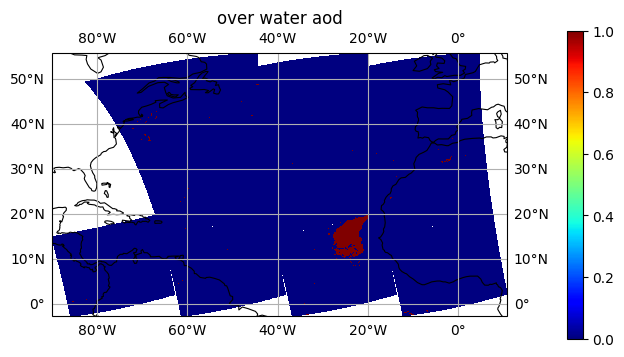

<Figure size 640x480 with 0 Axes>

In [38]:
plot_l2_product(lons, lats, masks[0], plot_range = plot_range, label='', title='over water aod', vmin = 0, vmax=1, cmap="jet")


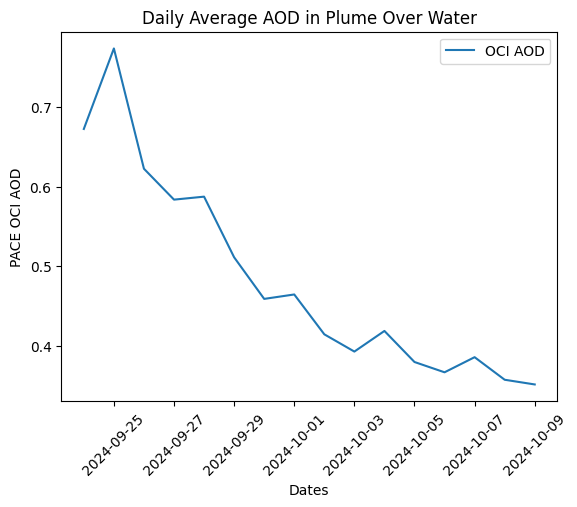

In [40]:
plt.plot(target_date_range,daily_AOD_anom_avg, label = 'OCI AOD')
plt.ylabel('PACE OCI AOD')
plt.xlabel('Dates')
plt.xticks(rotation = 45)
plt.title('Daily Average AOD in Plume Over Water')
plt.legend()